In [1]:
import numpy as np
import tensorflow as tf
# Set the seed for NumPy
np.random.seed(42)
# Set the seed for TensorFlow
tf.random.set_seed(42)

In [2]:
import os, glob
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from keras import regularizers
from tensorflow.keras.utils import load_img, img_to_array, array_to_img
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical

In [3]:
# Checking the contents of the xrays folder
data_dir = "data/AugmentedAlzheimerDataset/"
data_dir

'data/AugmentedAlzheimerDataset/'

In [4]:
# Gettting the list of folders from data dir
import os
subfolders = os.listdir(data_dir)
subfolders

['VeryMildDemented', 'ModerateDemented', 'MildDemented', 'NonDemented']

In [5]:
# Getting list of img file paths (no folders)
img_files = glob.glob(data_dir+"**/*")
len(img_files)

33984

In [6]:
# Take a look at the first 5 filepaths
img_files[0:5]

['data/AugmentedAlzheimerDataset/VeryMildDemented/2b70a7c4-b97a-4887-8e5f-85c079e7b275.jpg',
 'data/AugmentedAlzheimerDataset/VeryMildDemented/59bfe517-a5b4-4dd3-8e32-07fba7a77aa9.jpg',
 'data/AugmentedAlzheimerDataset/VeryMildDemented/ef1d73c2-679f-4421-b7c5-06881d487cf0.jpg',
 'data/AugmentedAlzheimerDataset/VeryMildDemented/716c42f4-f92c-40cd-9088-6254973a6665.jpg',
 'data/AugmentedAlzheimerDataset/VeryMildDemented/f897246c-1263-479b-8fe0-351e98cf7c9c.jpg']

In [7]:
# Preview an example image (at full size)
img_loaded = load_img(img_files[0])
img_data = img_to_array(img_loaded)
img_data.shape

(190, 200, 3)

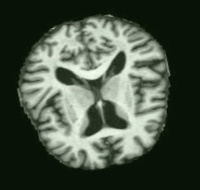

In [8]:
# Data can be converted back to image
array_to_img(img_data)

In [9]:
# Saving image params as vars for reuse
batch_size = 32
img_height = 190
img_width = 200

In [10]:
# make the dataset from the main folder of images
ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
    shuffle=True,
    label_mode='categorical',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
ds

Found 33984 files belonging to 4 classes.


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 190, 200, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [11]:
# Determine number of batches in dataset
ds_size = len(ds)
ds_size

1062

In [12]:
# taking a sample batch to see batch shape
example_batch_imgs,example_batch_y= ds.take(1).get_single_element()
example_batch_imgs.shape

TensorShape([32, 190, 200, 3])

In [13]:
# Preview y for first 5 of first batch
example_batch_y[0:5]

<tf.Tensor: shape=(5, 4), dtype=float32, numpy=
array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.]], dtype=float32)>

In [14]:
# checking the class names
class_names = ds.class_names
class_names

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

In [15]:
# Saving # of classes for reuse
num_classes = len(class_names)
num_classes

4

In [16]:
# Saving dictionary of integer:string labels
class_dict = dict(zip(range(num_classes), class_names))
class_dict

{0: 'MildDemented',
 1: 'ModerateDemented',
 2: 'NonDemented',
 3: 'VeryMildDemented'}

In [17]:
# Individual image shape
input_shape = example_batch_imgs[0].shape
input_shape

TensorShape([190, 200, 3])

In [18]:
# Demo Unpacking shape
input_shape = [*input_shape]
input_shape

[190, 200, 3]

In [19]:
# Set the ratio of the train, validation, test split
split_train = 0.7
split_val = 0.2
split_test = .1
# Calculate the number of batches for training and validation data
n_train_batches =  int(ds_size * split_train)
n_val_batches = int(ds_size * split_val)
print(f"Use {n_train_batches} batches as training data")
print(f"Use {n_val_batches} batches as validation data")
print(f"The remaining {len(ds)- (n_train_batches+n_val_batches)} batches will be used as test data.")

Use 743 batches as training data
Use 212 batches as validation data
The remaining 107 batches will be used as test data.


In [20]:
# Use .take to slice out the number of batches
train_ds = ds.take(n_train_batches)
# Confirm the length of the training set
len(train_ds)

743

In [21]:
# Skipover the training batches
val_ds = ds.skip(n_train_batches)
# Take the correct number of validation batches
val_ds = val_ds.take(n_val_batches)
# Confirm the length of the validation set
len(val_ds)

212

In [22]:
# Skip over all of the training + validation batches
test_ds = ds.skip(n_train_batches + n_val_batches)
# Confirm the length of the testing data
len(test_ds)

107

In [23]:
# The original (non-take/non-skip) dataset contains the class_names
class_names  = ds.class_names
class_names

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

In [24]:
# Write the building and compiling steps within a function
def build_model():
    # Instantatie model
    model = models.Sequential()
    # Scaling layer
    scaling_layer = layers.Rescaling(1./255, input_shape=input_shape)
    model.add(scaling_layer)

    # Convolutional layer
    model.add(
        layers.Conv2D(
            filters=8,  # How many filters you want to use
            kernel_size=3,  # size of each filter
            input_shape=input_shape,
            padding='same'
        ))
    # Pooling layer
    model.add(layers.MaxPooling2D(pool_size=2))  # Size of pooling
    # Convolutional layer
    model.add(
        layers.Conv2D(
            filters=8,  # How many filters you want to use
            kernel_size=3,  # size of each filter
            input_shape=input_shape,
            padding='same'
        ))
    # Pooling layer
    model.add(layers.MaxPooling2D(pool_size=2))  # Size of pooling

    # Flattening layer
    model.add(layers.Flatten())
    # Output layer
    model.add(
        layers.Dense(4, activation="softmax")  # How many output possibilities we have
    )  # What activation function are you using?

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()
    return model

In [27]:
# Build the model
model1 = build_model()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 190, 200, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 190, 200, 8)       224       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 95, 100, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 95, 100, 8)        584       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 47, 50, 8)         0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 18800)            

In [28]:
import datetime as dt
# timing
start = dt.datetime.now()

# fit the neural network
epochs=30
history = model1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
)

end = dt.datetime.now()
dur = end-start
print(f"Training time: {dur}")

Epoch 1/30
743/743 [==============================] - 50s 67ms/step - loss: 0.9819 - accuracy: 0.5643 - val_loss: 0.8196 - val_accuracy: 0.6465
Epoch 2/30
743/743 [==============================] - 50s 67ms/step - loss: 0.6958 - accuracy: 0.7158 - val_loss: 0.7024 - val_accuracy: 0.7208
Epoch 3/30
743/743 [==============================] - 50s 67ms/step - loss: 0.5523 - accuracy: 0.7853 - val_loss: 0.7073 - val_accuracy: 0.7273
Epoch 4/30
743/743 [==============================] - 50s 68ms/step - loss: 0.4602 - accuracy: 0.8272 - val_loss: 0.6574 - val_accuracy: 0.7588
Epoch 5/30
743/743 [==============================] - 50s 68ms/step - loss: 0.3892 - accuracy: 0.8551 - val_loss: 0.7381 - val_accuracy: 0.7587
Epoch 6/30
743/743 [==============================] - 50s 67ms/step - loss: 0.3290 - accuracy: 0.8803 - val_loss: 0.6950 - val_accuracy: 0.7869
Epoch 7/30
743/743 [==============================] - 50s 67ms/step - loss: 0.2831 - accuracy: 0.8968 - val_loss: 0.7650 - val_accuracy:

In [29]:
# Use autotune to automatically determine best buffer sizes
AUTOTUNE = tf.data.AUTOTUNE

In [30]:
# Make buffer size the same as the number of batches in train_ds
buffer_size = len(train_ds)
buffer_size

743

In [31]:
# Optimize training data
train_ds = train_ds.cache().shuffle(buffer_size= buffer_size,
                                   seed=42).prefetch(buffer_size=AUTOTUNE)
# Optimize validation data
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
# Optimize teset data
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [32]:
# Call build function to create identical model
model2 = build_model()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 190, 200, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 190, 200, 8)       224       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 95, 100, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 95, 100, 8)        584       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 47, 50, 8)         0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 18800)            

In [ ]:
# See how long it takes to fit the optimized dataset
# timing
start = dt.datetime.now()
# fit the neural network
epochs=30
history = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
)
end = dt.datetime.now()
dur2 = end-start
print(f"Training time: {dur2}")

Epoch 1/30
743/743 [==============================] - 58s 73ms/step - loss: 0.9714 - accuracy: 0.5674 - val_loss: 0.7958 - val_accuracy: 0.6803
Epoch 2/30
743/743 [==============================] - 54s 73ms/step - loss: 0.6951 - accuracy: 0.7161 - val_loss: 0.7051 - val_accuracy: 0.7201
Epoch 3/30
743/743 [==============================] - 54s 72ms/step - loss: 0.5624 - accuracy: 0.7789 - val_loss: 0.6582 - val_accuracy: 0.7471
Epoch 4/30
743/743 [==============================] - 56s 76ms/step - loss: 0.4751 - accuracy: 0.8190 - val_loss: 0.6347 - val_accuracy: 0.7675
Epoch 5/30
743/743 [==============================] - 55s 73ms/step - loss: 0.4032 - accuracy: 0.8483 - val_loss: 0.6458 - val_accuracy: 0.7799
Epoch 6/30
743/743 [==============================] - 55s 74ms/step - loss: 0.3466 - accuracy: 0.8729 - val_loss: 0.6689 - val_accuracy: 0.7832
Epoch 7/30
743/743 [==============================] - 54s 73ms/step - loss: 0.3039 - accuracy: 0.8882 - val_loss: 0.7045 - val_accuracy:

In [ ]:
print(f"The optimized dataset was {dur/dur2:.2f} times faster!")

In [ ]:
model1.save('model1_2')

In [ ]:
model2.save('model2_2')

In [ ]:
# Write the building and compiling steps within a function
def build_model():
    # Instantatie model
    model = models.Sequential()
    # Scaling layer
    scaling_layer = layers.Rescaling(1./255, input_shape=input_shape)
    model.add(scaling_layer)

    # Convolutional layer
    model.add(
        layers.Conv2D(
            filters=8,  # How many filters you want to use
            kernel_size=3,  # size of each filter
            input_shape=input_shape,
            padding='same'
        ))
    # Pooling layer
    model.add(layers.MaxPooling2D(pool_size=2))  # Size of pooling
    # Convolutional layer
    model.add(
        layers.Conv2D(
            filters=8,  # How many filters you want to use
            kernel_size=3,  # size of each filter
            input_shape=input_shape,
            padding='same'
        ))
    # Pooling layer
    model.add(layers.MaxPooling2D(pool_size=2))  # Size of pooling
    # Convolutional layer
    model.add(
        layers.Conv2D(
            filters=8,  # How many filters you want to use
            kernel_size=3,  # size of each filter
            input_shape=input_shape,
            padding='same'
        ))
    # Pooling layer
    model.add(layers.MaxPooling2D(pool_size=2))  # Size of pooling
        # Convolutional layer
    model.add(
        layers.Conv2D(
            filters=8,  # How many filters you want to use
            kernel_size=3,  # size of each filter
            input_shape=input_shape,
            padding='same'
        ))
    # Pooling layer
    model.add(layers.MaxPooling2D(pool_size=2))  # Size of pooling
        # Convolutional layer
    model.add(
        layers.Conv2D(
            filters=8,  # How many filters you want to use
            kernel_size=3,  # size of each filter
            input_shape=input_shape,
            padding='same'
        ))
    # Pooling layer
    model.add(layers.MaxPooling2D(pool_size=2))  # Size of pooling
    # Flattening layer
    model.add(layers.Flatten())
    # Output layer
    model.add(
        layers.Dense(4, activation="softmax")  # How many output possibilities we have
    )  # What activation function are you using?

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()
    return model

In [ ]:
# Call build function to create identical model
model3 = build_model()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 190, 200, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 190, 200, 8)       224       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 95, 100, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 95, 100, 8)        584       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 47, 50, 8)         0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 47, 50, 8)        

In [ ]:
import datetime as dt
# See how long it takes to fit the optimized dataset
# timing
start = dt.datetime.now()
# fit the neural network
epochs=10
history = model3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
)
end = dt.datetime.now()
dur2 = end-start
print(f"Training time: {dur2}")

Epoch 1/10
743/743 [==============================] - 136s 182ms/step - loss: 1.0932 - accuracy: 0.4908 - val_loss: 0.8945 - val_accuracy: 0.6075
Epoch 2/10
743/743 [==============================] - 140s 189ms/step - loss: 0.8449 - accuracy: 0.6209 - val_loss: 0.8139 - val_accuracy: 0.6403
Epoch 3/10
743/743 [==============================] - 133s 179ms/step - loss: 0.7696 - accuracy: 0.6581 - val_loss: 0.7689 - val_accuracy: 0.6564
Epoch 4/10
743/743 [==============================] - 137s 185ms/step - loss: 0.7228 - accuracy: 0.6791 - val_loss: 0.7338 - val_accuracy: 0.6907
Epoch 5/10
743/743 [==============================] - 139s 187ms/step - loss: 0.6879 - accuracy: 0.6995 - val_loss: 0.7034 - val_accuracy: 0.7018
Epoch 6/10
743/743 [==============================] - 141s 189ms/step - loss: 0.6613 - accuracy: 0.7135 - val_loss: 0.6682 - val_accuracy: 0.7168
Epoch 7/10
743/743 [==============================] - 139s 187ms/step - loss: 0.6415 - accuracy: 0.7235 - val_loss: 0.6699 -

In [ ]:
# Iterating through dataset object to separate image data from label data
for images, labels in test_ds.as_numpy_iterator():
    print(f'Image data shape is {images.shape}')
    print(f'Label data shape is {labels.shape}')

Image data shape is (32, 190, 200, 3)
Label data shape is (32, 4)
Image data shape is (32, 190, 200, 3)
Label data shape is (32, 4)
Image data shape is (32, 190, 200, 3)
Label data shape is (32, 4)
Image data shape is (32, 190, 200, 3)
Label data shape is (32, 4)
Image data shape is (32, 190, 200, 3)
Label data shape is (32, 4)
Image data shape is (32, 190, 200, 3)
Label data shape is (32, 4)
Image data shape is (32, 190, 200, 3)
Label data shape is (32, 4)
Image data shape is (32, 190, 200, 3)
Label data shape is (32, 4)
Image data shape is (32, 190, 200, 3)
Label data shape is (32, 4)
Image data shape is (32, 190, 200, 3)
Label data shape is (32, 4)
Image data shape is (32, 190, 200, 3)
Label data shape is (32, 4)
Image data shape is (32, 190, 200, 3)
Label data shape is (32, 4)
Image data shape is (32, 190, 200, 3)
Label data shape is (32, 4)
Image data shape is (32, 190, 200, 3)
Label data shape is (32, 4)
Image data shape is (32, 190, 200, 3)
Label data shape is (32, 4)
Image data

In [ ]:
# Previewing a label (y_true)
labels[0]

array([0., 0., 1., 0.], dtype=float32)

In [ ]:
# Obtain predictions from images
y_probs = model2.predict(images, batch_size=1)
y_probs[0]

32/32 [==============================] - 0s 2ms/step


array([8.9489234e-09, 2.5223669e-11, 9.9895716e-01, 1.0428483e-03],
      dtype=float32)

In [ ]:
def get_true_pred_labels(model,ds):
    """Gets the labels and predicted probabilities from a Tensorflow model and Dataset object.
    Adapted from source: https://stackoverflow.com/questions/66386561/keras-classification-report-accuracy-is-different-between-model-predict-accurac
    """
    y_true = []
    y_pred_probs = []

    # Loop through the dataset as a numpy iterator
    for images, labels in ds.as_numpy_iterator():

        # Get prediction with batch_size=1
        y_probs = model.predict(images, batch_size=1, verbose=0)
        # Combine previous labels/preds with new labels/preds
        y_true.extend(labels)
        y_pred_probs.extend(y_probs)
    ## Convert the lists to arrays
    y_true = np.array(y_true)
    y_pred_probs = np.array(y_pred_probs)

    return y_true, y_pred_probs

In [ ]:
%%time
# Using the function
y_test, y_pred_test = get_true_pred_labels(model2, test_ds)
print(f'Shape of y_test: {y_test.shape}')
print(f'Example of y_test: {y_test[0]}')
print(f'Shape of y_pred_test {y_pred_test.shape}')
print(f'Example of y_pred_test {y_pred_test[0]}')

Shape of y_test: (3424, 4)
Example of y_test: [0. 1. 0. 0.]
Shape of y_pred_test (3424, 4)
Example of y_pred_test [4.9418903e-11 9.9999428e-01 1.8353016e-10 5.6627705e-06]
CPU times: user 33.6 s, sys: 3.81 s, total: 37.4 s
Wall time: 14.6 s


In [ ]:
%%time
# Using the function
y_test, y_pred_test = get_true_pred_labels(model3, test_ds)
print(f'Shape of y_test: {y_test.shape}')
print(f'Example of y_test: {y_test[0]}')
print(f'Shape of y_pred_test {y_pred_test.shape}')
print(f'Example of y_pred_test {y_pred_test[0]}')

Shape of y_test: (3424, 4)
Example of y_test: [0. 1. 0. 0.]
Shape of y_pred_test (3424, 4)
Example of y_pred_test [1.2538098e-04 9.9818403e-01 1.3012801e-04 1.5604079e-03]
CPU times: user 34.1 s, sys: 3.33 s, total: 37.4 s
Wall time: 14.1 s


In [ ]:
def convert_y_to_sklearn_classes(y, verbose=False):
    # If already one-dimension
    if np.ndim(y)==1:
        if verbose:
            print("- y is 1D, using it as-is.")
        return y

    # If 2 dimensions with more than 1 column:
    elif y.shape[1]>1:
        if verbose:
            print("- y is 2D with >1 column. Using argmax for metrics.")
        return np.argmax(y, axis=1)

    else:
        if verbose:
            print("y is 2D with 1 column. Using round for metrics.")
        return np.round(y).flatten().astype(int)

In [ ]:
# Test function
y_preds_transformed = convert_y_to_sklearn_classes(y_pred_test, verbose = True)
y_preds_transformed[:5]

- y is 2D with >1 column. Using argmax for metrics.


array([1, 0, 2, 0, 3])

In [ ]:
## PREVIOUS CLASSIFICATION_METRICS FUNCTION FROM INTRO TO ML
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False,values_format=".2f"):
    """Modified version of classification metrics function from Intro to Machine Learning.
    Updates:
    - Reversed raw counts confusion matrix cmap  (so darker==more).
    - Added arg for normalized confusion matrix values_format
    """
    # Get the classification report
    report = classification_report(y_true, y_pred)

    ## Print header and report
    header = "-"*70
    print(header, f" Classification Metrics: {label}", header, sep='\n')
    print(report)

    ## CONFUSION MATRICES SUBPLOTS
    fig, axes = plt.subplots(ncols=2, figsize=figsize)

    # Create a confusion matrix  of raw counts (left subplot)
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=None,
                                            cmap='gist_gray_r',# Updated cmap
                                            values_format="d",
                                            colorbar=colorbar,
                                            ax = axes[0]);
    axes[0].set_title("Raw Counts")


    # Create a confusion matrix with the data with normalize argument
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=normalize,
                                            cmap=cmap,
                                            values_format=values_format, #New arg
                                            colorbar=colorbar,
                                            ax = axes[1]);
    axes[1].set_title("Normalized Confusion Matrix")

    # Adjust layout and show figure
    fig.tight_layout()
    plt.show()

    # Return dictionary of classification_report
    if output_dict==True:
        report_dict = classification_report(y_true, y_pred, output_dict=True)
        return report_dict



## PLOT_HISTORY FUNCTION FROM WEEK 3
def plot_history(history,figsize=(6,8)):
    # Get a unique list of metrics
    all_metrics = np.unique([k.replace('val_','') for k in history.history.keys()])

    # Plot each metric
    n_plots = len(all_metrics)
    fig, axes = plt.subplots(nrows=n_plots, figsize=figsize)
    axes = axes.flatten()

    # Loop through metric names add get an index for the axes
    for i, metric in enumerate(all_metrics):

        # Get the epochs and metric values
        epochs = history.epoch
        score = history.history[metric]

        # Plot the training results
        axes[i].plot(epochs, score, label=metric, marker='.')
        # Plot val results (if they exist)
        try:
            val_score = history.history[f"val_{metric}"]
            axes[i].plot(epochs, val_score, label=f"val_{metric}",marker='.')
        except:
            pass

        finally:
            axes[i].legend()
            axes[i].set(title=metric, xlabel="Epoch",ylabel=metric)

    # Adjust subplots and show
    fig.tight_layout()
    plt.show()

In [ ]:
## PREVIOUS CLASSIFICATION_METRICS FUNCTION FROM INTRO TO ML
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False,values_format=".2f"):
    """Modified version of classification metrics function from Intro to Machine Learning.
    Updates:
    - Reversed raw counts confusion matrix cmap  (so darker==more).
    - Added arg for normalized confusion matrix values_format
    """
    # Get the classification report
    report = classification_report(y_true, y_pred)

    ## Print header and report
    header = "-"*70
    print(header, f" Classification Metrics: {label}", header, sep='\n')
    print(report)

    ## CONFUSION MATRICES SUBPLOTS
    fig, axes = plt.subplots(ncols=2, figsize=figsize)

    # Create a confusion matrix  of raw counts (left subplot)
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=None,
                                            cmap='gist_gray_r',# Updated cmap
                                            values_format="d",
                                            colorbar=colorbar,
                                            ax = axes[0]);
    axes[0].set_title("Raw Counts")


    # Create a confusion matrix with the data with normalize argument
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=normalize,
                                            cmap=cmap,
                                            values_format=values_format, #New arg
                                            colorbar=colorbar,
                                            ax = axes[1]);
    axes[1].set_title("Normalized Confusion Matrix")

    # Adjust layout and show figure
    fig.tight_layout()
    plt.show()

    # Return dictionary of classification_report
    if output_dict==True:
        report_dict = classification_report(y_true, y_pred, output_dict=True)
        return report_dict



## PLOT_HISTORY FUNCTION FROM WEEK 3
def plot_history(history,figsize=(6,8)):
    # Get a unique list of metrics
    all_metrics = np.unique([k.replace('val_','') for k in history.history.keys()])

    # Plot each metric
    n_plots = len(all_metrics)
    fig, axes = plt.subplots(nrows=n_plots, figsize=figsize)
    axes = axes.flatten()

    # Loop through metric names add get an index for the axes
    for i, metric in enumerate(all_metrics):

        # Get the epochs and metric values
        epochs = history.epoch
        score = history.history[metric]

        # Plot the training results
        axes[i].plot(epochs, score, label=metric, marker='.')
        # Plot val results (if they exist)
        try:
            val_score = history.history[f"val_{metric}"]
            axes[i].plot(epochs, val_score, label=f"val_{metric}",marker='.')
        except:
            pass

        finally:
            axes[i].legend()
            axes[i].set(title=metric, xlabel="Epoch",ylabel=metric)

    # Adjust subplots and show
    fig.tight_layout()
    plt.show()

In [ ]:
def evaluate_classification_network(model,
                                    X_train=None, y_train=None,
                                    X_test=None, y_test=None,
                                    history=None, history_figsize=(6,6),
                                    figsize=(6,4), normalize='true',
                                    output_dict = False,
                                    cmap_train='Blues',
                                    cmap_test="Reds",
                                    values_format=".2f",
                                    colorbar=False):
    """Evaluates a neural network classification task using either
    separate X and y arrays or a tensorflow Dataset

    Data Args:
        X_train (array, or Dataset)
        y_train (array, or None if using a Dataset
        X_test (array, or Dataset)
        y_test (array, or None if using a Dataset)
        history (history object)
        """
    # Plot history, if provided
    if history is not None:
        plot_history(history, figsize=history_figsize)
    ## Adding a Print Header
    print("\n"+'='*80)
    print('- Evaluating Network...')
    print('='*80)
    ## TRAINING DATA EVALUATION
    # check if X_train was provided
    if X_train is not None:
        ## Check if X_train is a dataset
        if hasattr(X_train,'map'):
            # If it IS a Datset:
            # extract y_train and y_train_pred with helper function
            y_train, y_train_pred = get_true_pred_labels(model, X_train)
        else:
            # Get predictions for training data
            y_train_pred = model.predict(X_train)
        ## Pass both y-vars through helper compatibility function
        y_train = convert_y_to_sklearn_classes(y_train)
        y_train_pred = convert_y_to_sklearn_classes(y_train_pred)

        # Call the helper function to obtain regression metrics for training data
        results_train = classification_metrics(y_train, y_train_pred,
                                         output_dict=True, figsize=figsize,
                                             colorbar=colorbar, cmap=cmap_train,
                                               values_format=values_format,
                                         label='Training Data')

        ## Run model.evaluate
        print("\n- Evaluating Training Data:")
        print(model.evaluate(X_train, return_dict=True))

    # If no X_train, then save empty list for results_train
    else:
        results_train = []
    ## TEST DATA EVALUATION
    # check if X_test was provided
    if X_test is not None:
        ## Check if X_train is a dataset
        if hasattr(X_test,'map'):
            # If it IS a Datset:
            # extract y_train and y_train_pred with helper function
            y_test, y_test_pred = get_true_pred_labels(model, X_test)
        else:
            # Get predictions for training data
            y_test_pred = model.predict(X_test)
        ## Pass both y-vars through helper compatibility function
        y_test = convert_y_to_sklearn_classes(y_test)
        y_test_pred = convert_y_to_sklearn_classes(y_test_pred)

        # Call the helper function to obtain regression metrics for training data
        results_test = classification_metrics(y_test, y_test_pred,
                                         output_dict=True, figsize=figsize,
                                             colorbar=colorbar, cmap=cmap_test,
                                              values_format=values_format,
                                         label='Test Data')

        ## Run model.evaluate
        print("\n- Evaluating Test Data:")
        print(model.evaluate(X_test, return_dict=True))

    # If no X_test, then save empty list for results_test
    else:
        results_test = []

    # Store results in a dictionary
    results_dict = {'train':results_train,
                    'test': results_test}
    if output_dict == True:
        return results_dict

In [ ]:
# Testing with the CNN + Dataset
evaluate_classification_network(model1, X_test=test_ds, history=history);

In [ ]:
# Testing with the CNN + Dataset
evaluate_classification_network(model1, X_test=test_ds, history=history);

In [ ]:
# Testing with the CNN + Dataset
evaluate_classification_network(model2, X_test=test_ds, history=history);

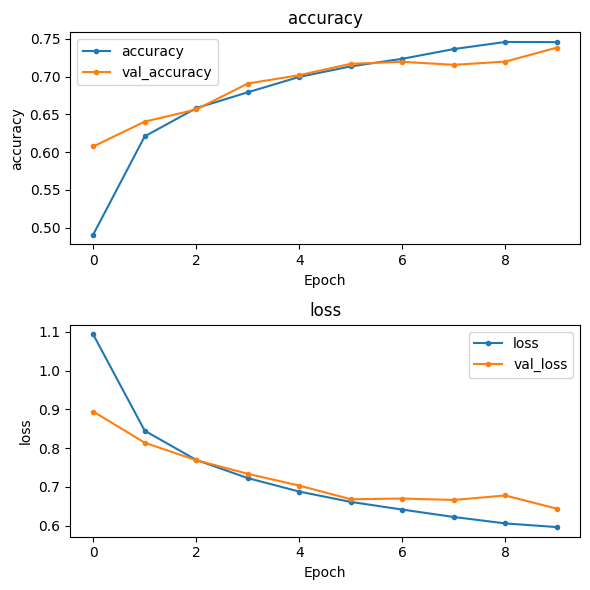


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.70      0.82      0.75       901
           1       0.95      0.98      0.96       658
           2       0.72      0.69      0.70      1012
           3       0.60      0.51      0.55       853

    accuracy                           0.73      3424
   macro avg       0.74      0.75      0.74      3424
weighted avg       0.73      0.73      0.73      3424



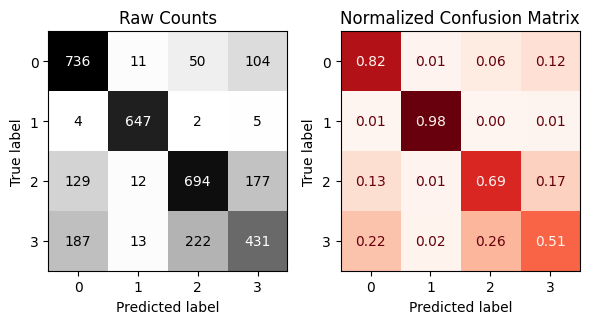


- Evaluating Test Data:
107/107 [==============================] - 4s 33ms/step - loss: 0.6391 - accuracy: 0.7325
{'loss': 0.6390586495399475, 'accuracy': 0.7324766516685486}


In [ ]:
# Testing with the CNN + Dataset
evaluate_classification_network(model3, X_test=test_ds, history=history);

In [ ]:
model1.save('model1.h5')

/usr/local/anaconda3/envs/ml/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model2.save('model2.h5')

In [ ]:
model3.save('model3.h5')

In [ ]:
model2

In [ ]:
# from tensorflow.keras.preprocessing import image
# img = image.load_img('./data/xRays/normal/00000007_000.png',target_size=(96, 96))
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)
# img_array /= 255.0  # Normalize the image
# predictions = model2.predict(img_array)
# print(predictions)
# predicted_class = np.argmax(predictions[0])
# confidence_percent = round((np.max(predictions[0]) * 100 ),3)
# print(predicted_class)
# print(class_names[predicted_class])
# print(confidence_percent)

In [ ]:
print(model2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 190, 200, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 190, 200, 8)       224       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 95, 100, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 95, 100, 8)        584       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 47, 50, 8)         0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 18800)            

In [ ]:
# Write the building and compiling steps within a function
def build_model():
    # Instantatie model
    model = models.Sequential()
    # Scaling layer
    scaling_layer = layers.Rescaling(1./255, input_shape=input_shape)
    model.add(scaling_layer)

    # Convolutional layer
    model.add(
        layers.Conv2D(
            filters=16,  # How many filters you want to use
            kernel_size=3,  # size of each filter
            input_shape=input_shape,
            padding='same'
        ))
    # Pooling layer
    model.add(layers.MaxPooling2D(pool_size=2))  # Size of pooling
    # Convolutional layer
    model.add(
        layers.Conv2D(
            filters=16,  # How many filters you want to use
            kernel_size=3,  # size of each filter
            input_shape=input_shape,
            padding='same'
        ))
    # Pooling layer
    model.add(layers.MaxPooling2D(pool_size=2))  # Size of pooling
    # Convolutional layer
    model.add(
        layers.Conv2D(
            filters=8,  # How many filters you want to use
            kernel_size=3,  # size of each filter
            input_shape=input_shape,
            padding='same'
        ))
    # Pooling layer
    model.add(layers.MaxPooling2D(pool_size=2))  # Size of pooling
        # Convolutional layer
    model.add(
        layers.Conv2D(
            filters=8,  # How many filters you want to use
            kernel_size=3,  # size of each filter
            input_shape=input_shape,
            padding='same'
        ))
    # Pooling layer
    model.add(layers.MaxPooling2D(pool_size=2))  # Size of pooling
        # Convolutional layer
    model.add(
        layers.Conv2D(
            filters=8,  # How many filters you want to use
            kernel_size=3,  # size of each filter
            input_shape=input_shape,
            padding='same'
        ))
    # Pooling layer
    model.add(layers.MaxPooling2D(pool_size=2))  # Size of pooling
    # Flattening layer
    model.add(layers.Flatten())
    # Output layer
    model.add(
        layers.Dense(4, activation="softmax")  # How many output possibilities we have
    )  # What activation function are you using?

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()
    return model

In [ ]:
print(len(train_ds))
model5 = build_model()

743
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 190, 200, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 190, 200, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 95, 100, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 95, 100, 16)       2320      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 47, 50, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 47, 50, 8)    

In [ ]:
# See how long it takes to fit the optimized dataset
# timing
start = dt.datetime.now()
# fit the neural network
epochs=10
history = model5.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
)
end = dt.datetime.now()
dur2 = end-start
print(f"Training time: {dur2}")

Epoch 1/10
743/743 [==============================] - 187s 250ms/step - loss: 1.0891 - accuracy: 0.4981 - val_loss: 0.8897 - val_accuracy: 0.6191
Epoch 2/10
743/743 [==============================] - 183s 246ms/step - loss: 0.8137 - accuracy: 0.6372 - val_loss: 0.7596 - val_accuracy: 0.6766
Epoch 3/10
743/743 [==============================] - 189s 254ms/step - loss: 0.7303 - accuracy: 0.6780 - val_loss: 0.7383 - val_accuracy: 0.6792
Epoch 4/10
743/743 [==============================] - 195s 262ms/step - loss: 0.6794 - accuracy: 0.7070 - val_loss: 0.7393 - val_accuracy: 0.6865
Epoch 5/10
743/743 [==============================] - 197s 265ms/step - loss: 0.6412 - accuracy: 0.7277 - val_loss: 0.6608 - val_accuracy: 0.7174
Epoch 6/10
743/743 [==============================] - 183s 246ms/step - loss: 0.6098 - accuracy: 0.7408 - val_loss: 0.6457 - val_accuracy: 0.7295
Epoch 7/10
743/743 [==============================] - 183s 247ms/step - loss: 0.5853 - accuracy: 0.7540 - val_loss: 0.6116 -

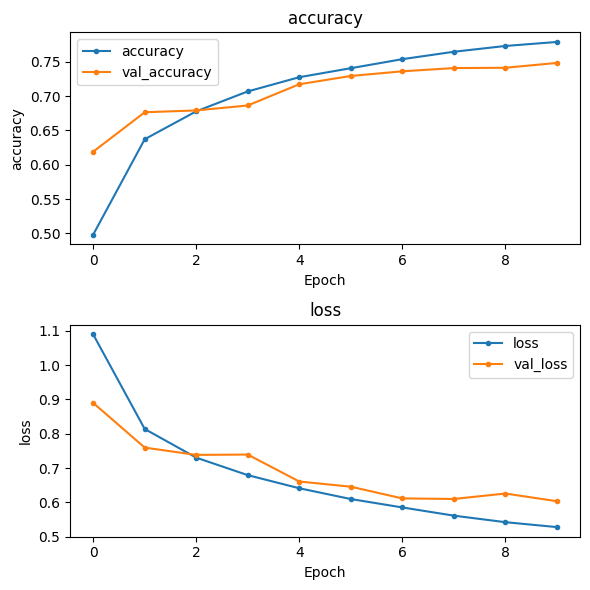


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.75      0.79      0.77       901
           1       0.95      0.97      0.96       658
           2       0.76      0.64      0.70      1012
           3       0.58      0.64      0.61       853

    accuracy                           0.74      3424
   macro avg       0.76      0.76      0.76      3424
weighted avg       0.75      0.74      0.74      3424



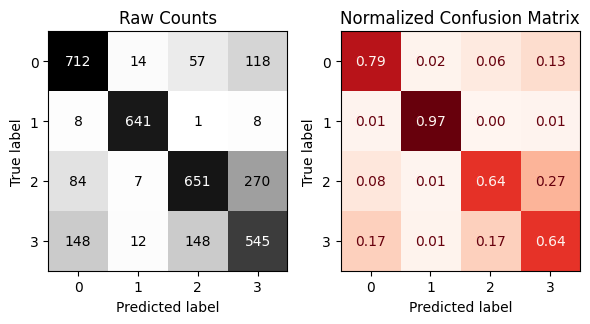


- Evaluating Test Data:
107/107 [==============================] - 5s 47ms/step - loss: 0.5942 - accuracy: 0.7445
{'loss': 0.5942081809043884, 'accuracy': 0.7444509267807007}


In [ ]:
# Testing with the CNN + Dataset
evaluate_classification_network(model5, X_test=test_ds, history=history);

In [ ]:
model5.save('model5.h5')

/usr/local/anaconda3/envs/ml/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Write the building and compiling steps within a function
def build_model():
    # Instantatie model
    model = models.Sequential()
    # Scaling layer
    scaling_layer = layers.Rescaling(1./255, input_shape=input_shape)
    model.add(scaling_layer)

    # Convolutional layer
    model.add(
        layers.Conv2D(
            filters=16,  # How many filters you want to use
            kernel_size=3,  # size of each filter
            input_shape=input_shape,
            padding='same'
        ))
    # Pooling layer
    model.add(layers.MaxPooling2D(pool_size=2))  # Size of pooling
    # Convolutional layer
    model.add(
        layers.Conv2D(
            filters=16,  # How many filters you want to use
            kernel_size=3,  # size of each filter
            input_shape=input_shape,
            padding='same'
        ))
    # Pooling layer
    model.add(layers.MaxPooling2D(pool_size=2))  # Size of pooling
    model.add(layers.Dropout(0.2))  # Dropout layer
    # Convolutional layer
    model.add(
        layers.Conv2D(
            filters=8,  # How many filters you want to use
            kernel_size=3,  # size of each filter
            input_shape=input_shape,
            padding='same'
        ))
    # Pooling layer
    model.add(layers.MaxPooling2D(pool_size=2))  # Size of pooling
        # Convolutional layer
    model.add(
        layers.Conv2D(
            filters=8,  # How many filters you want to use
            kernel_size=3,  # size of each filter
            input_shape=input_shape,
            padding='same'
        ))
    # Pooling layer
    model.add(layers.MaxPooling2D(pool_size=2))  # Size of pooling
    model.add(layers.Dropout(0.2))  # Dropout layer
        # Convolutional layer
    model.add(
        layers.Conv2D(
            filters=8,  # How many filters you want to use
            kernel_size=3,  # size of each filter
            input_shape=input_shape,
            padding='same'
        ))
    # Pooling layer
    model.add(layers.MaxPooling2D(pool_size=2))  # Size of pooling
    # Flattening layer
    model.add(layers.Flatten())
    # Output layer
    model.add(
        layers.Dense(4, activation="softmax")  # How many output possibilities we have
    )  # What activation function are you using?

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()
    return model

In [ ]:
model6 = build_model()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 190, 200, 3)       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 190, 200, 16)      448       
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 95, 100, 16)       0         
 ng2D)                                                           
                                                                 
 conv2d_15 (Conv2D)          (None, 95, 100, 16)       2320      
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 47, 50, 16)        0         
 ng2D)                                                           
                                                                 
 dropout (Dropout)           (None, 47, 50, 16)       

In [ ]:
# See how long it takes to fit the optimized dataset
# timing
start = dt.datetime.now()
# fit the neural network
epochs=10
history = model6.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
)
end = dt.datetime.now()
dur2 = end-start
print(f"Training time: {dur2}")

Epoch 1/10
743/743 [==============================] - 202s 271ms/step - loss: 1.2153 - accuracy: 0.4253 - val_loss: 1.0211 - val_accuracy: 0.5672
Epoch 2/10
743/743 [==============================] - 201s 270ms/step - loss: 0.9773 - accuracy: 0.5578 - val_loss: 0.8378 - val_accuracy: 0.6256
Epoch 3/10
743/743 [==============================] - 201s 270ms/step - loss: 0.8692 - accuracy: 0.6041 - val_loss: 0.7719 - val_accuracy: 0.6676
Epoch 4/10
743/743 [==============================] - 200s 269ms/step - loss: 0.8170 - accuracy: 0.6288 - val_loss: 0.7153 - val_accuracy: 0.6843
Epoch 5/10
743/743 [==============================] - 200s 270ms/step - loss: 0.7784 - accuracy: 0.6469 - val_loss: 0.7074 - val_accuracy: 0.6815
Epoch 6/10
743/743 [==============================] - 200s 269ms/step - loss: 0.7543 - accuracy: 0.6641 - val_loss: 0.6688 - val_accuracy: 0.7155
Epoch 7/10
743/743 [==============================] - 200s 269ms/step - loss: 0.7346 - accuracy: 0.6726 - val_loss: 0.6534 -

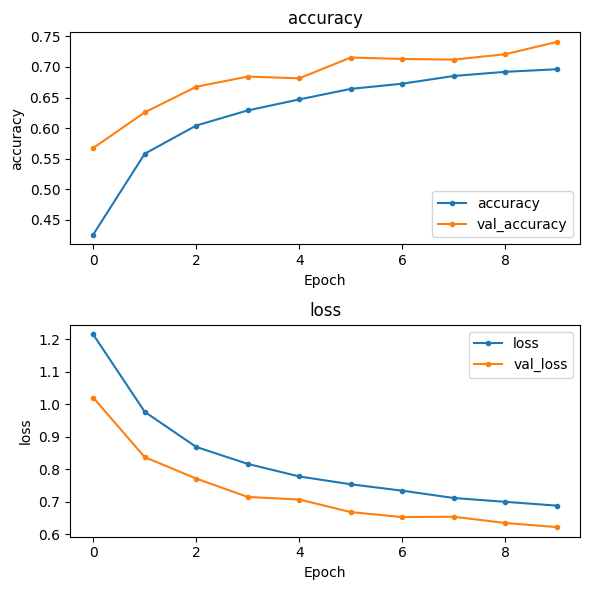


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.65      0.85      0.74       901
           1       0.97      0.97      0.97       658
           2       0.76      0.68      0.72      1012
           3       0.60      0.47      0.53       853

    accuracy                           0.73      3424
   macro avg       0.74      0.74      0.74      3424
weighted avg       0.73      0.73      0.72      3424



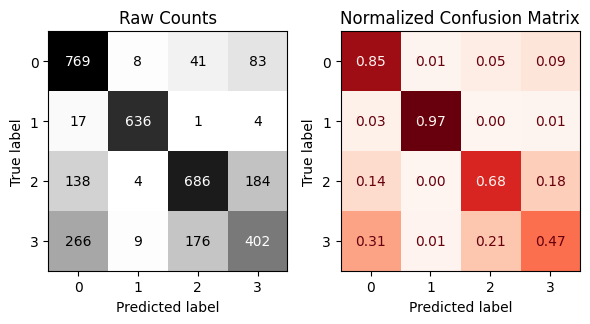


- Evaluating Test Data:
107/107 [==============================] - 5s 48ms/step - loss: 0.6342 - accuracy: 0.7281
{'loss': 0.6341560482978821, 'accuracy': 0.7280957698822021}


In [ ]:
# Testing with the CNN + Dataset
evaluate_classification_network(model6, X_test=test_ds, history=history);

In [ ]:
model6.save('model6.h5')

/usr/local/anaconda3/envs/ml/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Write the building and compiling steps within a function
def build_model():
    # Instantatie model
    model = models.Sequential()
    # Scaling layer
    scaling_layer = layers.Rescaling(1./255, input_shape=input_shape)
    model.add(scaling_layer)

    # Convolutional layer
    model.add(
        layers.Conv2D(
            filters=8,  # How many filters you want to use
            kernel_size=3,  # size of each filter
            input_shape=input_shape,
            padding='same'
        ))
    # Pooling layer
    model.add(layers.MaxPooling2D(pool_size=2))  # Size of pooling
    model.add(layers.Dense(500,kernel_regularizer=regularizers.l2(0.01),activation="relu")) # R2 regularizer
    model.add(layers.Dropout(0.2))  # Dropout layer
    # Convolutional layer
    model.add(
        layers.Conv2D(
            filters=8,  # How many filters you want to use
            kernel_size=3,  # size of each filter
            input_shape=input_shape,
            padding='same'
        ))
    # Pooling layer
    model.add(layers.MaxPooling2D(pool_size=2))  # Size of pooling
    model.add(layers.Dense(500,kernel_regularizer=regularizers.l2(0.01),activation="relu")) # R2 regularizer
    model.add(layers.Dropout(0.2))  # Dropout layer
    # Convolutional layer
    model.add(
        layers.Conv2D(
            filters=8,  # How many filters you want to use
            kernel_size=3,  # size of each filter
            input_shape=input_shape,
            padding='same'
        ))
    # Pooling layer
    model.add(layers.MaxPooling2D(pool_size=2))  # Size of pooling
    model.add(layers.Dense(500,kernel_regularizer=regularizers.l2(0.01),activation="relu")) # R2 regularizer
    model.add(layers.Dropout(0.2))  # Dropout layer
    # Flattening layer
    model.add(layers.Flatten())
    # Output layer
    model.add(
        layers.Dense(4, activation="softmax")  # How many output possibilities we have
    )  # What activation function are you using?

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()
    return model



In [ ]:
model7 = build_model()
# See how long it takes to fit the optimized dataset
# timing
start = dt.datetime.now()
# fit the neural network
epochs=10
history = model7.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
)
end = dt.datetime.now()
dur2 = end-start
print(f"Training time: {dur2}")

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 190, 200, 3)       0         
                                                                 
 conv2d_19 (Conv2D)          (None, 190, 200, 8)       224       
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 95, 100, 8)        0         
 ng2D)                                                           
                                                                 
 dense_5 (Dense)             (None, 95, 100, 500)      4500      
                                                                 
 dropout_2 (Dropout)         (None, 95, 100, 500)      0         
                                                                 
 conv2d_20 (Conv2D)          (None, 95, 100, 8)        36008     
                                                      

In [ ]:
# Testing with the CNN + Dataset
evaluate_classification_network(model7, X_test=test_ds, history=history);

In [ ]:
model7.save('model7_pt2.h5')